In [1]:
import torch
import torch.nn as nn
import time
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Define mean and standard deviation for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(5, shear=5, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.5, contrast=0.6, saturation=0.5),
    # transforms.RandomAffine(10, shear=7, scale=(0.5, 1.4)),
    # transforms.RandomVerticalFlip(),
    # transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.2),
    # transforms.RandomAffine(15, shear=8, scale=(0.6, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

training_dataset = datasets.ImageFolder('train', transform=transform_train)
validation_dataset = datasets.ImageFolder('val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [3]:
def im_convert(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array(std) + np.array(mean)
    image = image.clip(0, 1)
    return image

In [4]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
            nn.BatchNorm2d(out_channels)
        ) if stride != 1 or in_channels != out_channels else None

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class CNNWithSkipConnections(nn.Module):
    def __init__(self, num_classes=6):
        super(CNNWithSkipConnections, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(64, 3)
        self.layer2 = self.make_layer(128, 4, stride=2)
        self.layer3 = self.make_layer(256, 6, stride=2)
        self.layer4 = self.make_layer(512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [5]:
# Initialize the model
model = CNNWithSkipConnections(num_classes=6)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNNWithSkipConnections(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kern

In [6]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [7]:
# Define lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Set number of epochs
num_epochs = 70

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    train_correct = 0
    train_loss = 0.0
    start_epoch_time = time.time()

    for images, labels in training_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_loss += loss.item()

    # Compute average training loss and accuracy
    train_accuracy = train_correct / len(training_loader.dataset)
    train_loss /= len(training_loader)
    epoch_time = time.time() - start_epoch_time

    # Append training loss and accuracy to lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on validation set
    model.eval()
    val_correct = 0
    val_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_loss += loss.item()
            total_samples += labels.size(0)

    # Compute average validation loss and accuracy
    val_accuracy = val_correct / total_samples
    val_loss /= len(validation_loader)

    # Append validation loss and accuracy to lists
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, '
          f'Time: {epoch_time:.2f} seconds')

total_training_time = time.time() - start_time
total_training_time_hours = total_training_time / 3600
print(f'Total Training Time: {total_training_time_hours:.2f} hours')

Epoch [1/70], Train Loss: 1.8206, Train Accuracy: 0.2636, Validation Loss: 2.0538, Validation Accuracy: 0.2819, Time: 13.92 seconds
Epoch [2/70], Train Loss: 1.6128, Train Accuracy: 0.3360, Validation Loss: 1.5552, Validation Accuracy: 0.4295, Time: 14.16 seconds
Epoch [3/70], Train Loss: 1.5404, Train Accuracy: 0.3580, Validation Loss: 1.6513, Validation Accuracy: 0.3874, Time: 14.13 seconds
Epoch [4/70], Train Loss: 1.5269, Train Accuracy: 0.3891, Validation Loss: 1.4526, Validation Accuracy: 0.4295, Time: 14.32 seconds
Epoch [5/70], Train Loss: 1.4975, Train Accuracy: 0.4084, Validation Loss: 1.5523, Validation Accuracy: 0.4097, Time: 14.47 seconds
Epoch [6/70], Train Loss: 1.4855, Train Accuracy: 0.4084, Validation Loss: 1.4835, Validation Accuracy: 0.4717, Time: 14.04 seconds
Epoch [7/70], Train Loss: 1.4541, Train Accuracy: 0.4197, Validation Loss: 1.6443, Validation Accuracy: 0.4427, Time: 14.32 seconds
Epoch [8/70], Train Loss: 1.4439, Train Accuracy: 0.4406, Validation Loss: 1

Epoch [63/70], Train Loss: 0.8773, Train Accuracy: 0.6889, Validation Loss: 0.8012, Validation Accuracy: 0.7194, Time: 14.75 seconds
Epoch [64/70], Train Loss: 0.8587, Train Accuracy: 0.6917, Validation Loss: 0.9594, Validation Accuracy: 0.6706, Time: 14.70 seconds
Epoch [65/70], Train Loss: 0.8633, Train Accuracy: 0.6850, Validation Loss: 0.8120, Validation Accuracy: 0.7075, Time: 14.72 seconds
Epoch [66/70], Train Loss: 0.8319, Train Accuracy: 0.6912, Validation Loss: 1.1733, Validation Accuracy: 0.5982, Time: 14.72 seconds
Epoch [67/70], Train Loss: 0.8431, Train Accuracy: 0.6889, Validation Loss: 0.9720, Validation Accuracy: 0.6232, Time: 14.70 seconds
Epoch [68/70], Train Loss: 0.8516, Train Accuracy: 0.6906, Validation Loss: 0.9394, Validation Accuracy: 0.6680, Time: 14.72 seconds
Epoch [69/70], Train Loss: 0.8006, Train Accuracy: 0.7048, Validation Loss: 0.9864, Validation Accuracy: 0.6416, Time: 14.84 seconds
Epoch [70/70], Train Loss: 0.8252, Train Accuracy: 0.7053, Validation

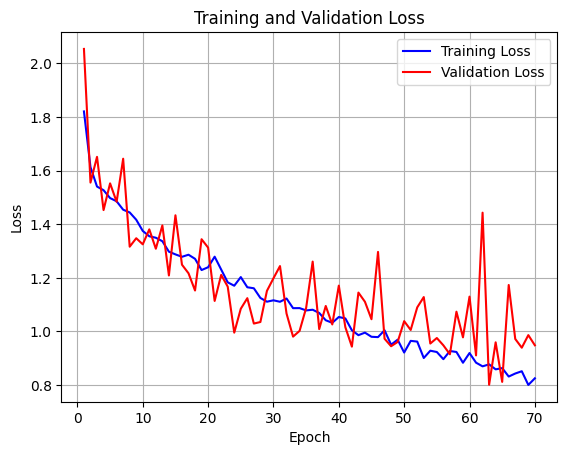

In [8]:
# Plot training loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

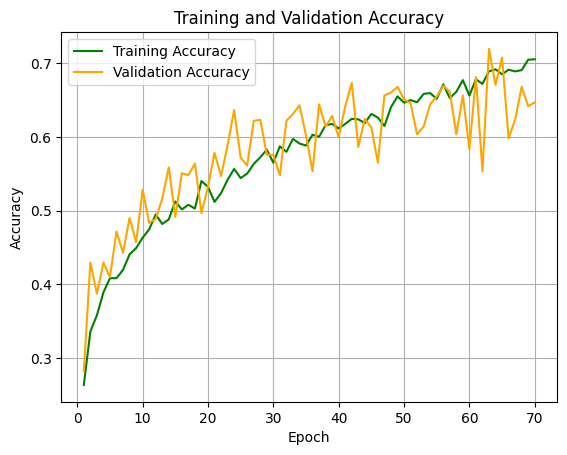

In [9]:
# Plot training accuracy
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='green')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics for training data
train_preds = []
train_targets = []

model.eval()
with torch.no_grad():
    for images, labels in training_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        train_preds.extend(predicted.cpu().numpy())
        train_targets.extend(labels.cpu().numpy())

train_acc = accuracy_score(train_targets, train_preds)
train_precision = precision_score(train_targets, train_preds, average='weighted')
train_recall = recall_score(train_targets, train_preds, average='weighted')
train_f1 = f1_score(train_targets, train_preds, average='weighted')

print("Training Metrics:")
print(f"Accuracy: {train_acc:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-score: {train_f1:.4f}")

Training Metrics:
Accuracy: 0.7200
Precision: 0.7333
Recall: 0.7200
F1-score: 0.7166


In [11]:
# Calculate metrics for validation data
val_preds = []
val_targets = []

with torch.no_grad():
    for images, labels in validation_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        val_preds.extend(predicted.cpu().numpy())
        val_targets.extend(labels.cpu().numpy())

val_acc = accuracy_score(val_targets, val_preds)
val_precision = precision_score(val_targets, val_preds, average='weighted')
val_recall = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')

print("\nValidation Metrics:")
print(f"Accuracy: {val_acc:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1-score: {val_f1:.4f}")


Validation Metrics:
Accuracy: 0.6469
Precision: 0.6916
Recall: 0.6469
F1-score: 0.6421


Confusion Matrix (Validation Data):
[[ 99   8   3   2   3   1]
 [  2 119  18   0   6   2]
 [  5  23  84   5   5   2]
 [ 40  25   9 112   2   3]
 [ 20  28  12   5  66   4]
 [  4  22   8   0   1  11]]


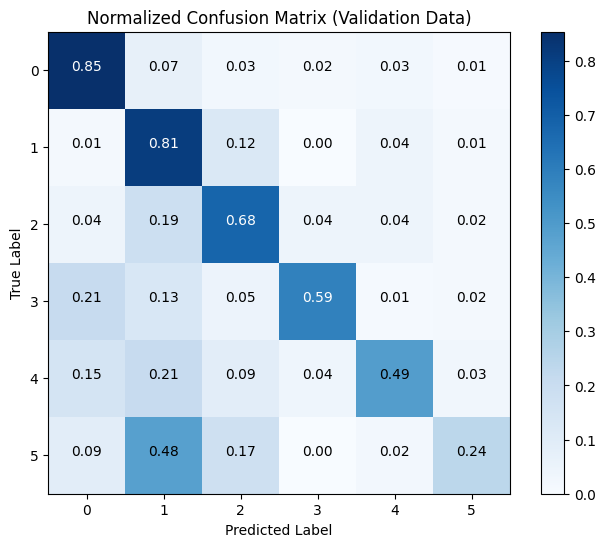

In [12]:
# Assuming val_targets and val_preds are your actual and predicted labels
conf_matrix_val = confusion_matrix(val_targets, val_preds)

# Calculate normalized values
conf_matrix_val_normalized = conf_matrix_val.astype('float') / conf_matrix_val.sum(axis=1)[:, np.newaxis]

# Print and plot confusion matrix for validation data
print("Confusion Matrix (Validation Data):")
print(conf_matrix_val)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_val_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix (Validation Data)')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Display the normalized values in each cell
for i in range(conf_matrix_val_normalized.shape[0]):
    for j in range(conf_matrix_val_normalized.shape[1]):
        plt.text(j, i, format(conf_matrix_val_normalized[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if conf_matrix_val_normalized[i, j] > 0.5 else "black")

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


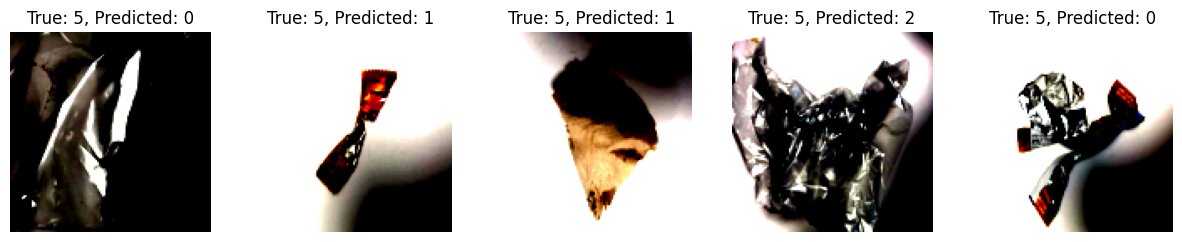

In [13]:
# Convert to numpy arrays for visualization
images_np = images.cpu().numpy()
labels_np = labels.cpu().numpy()
preds_np = val_preds  # Assuming val_preds is a PyTorch tensor

# Visualize some random images along with true and predicted labels
num_images_to_display = 5
random_indices = np.random.choice(len(images_np), num_images_to_display, replace=False)

plt.figure(figsize=(15, 3))  # Adjust the figure size as needed

for i, index in enumerate(random_indices):
    plt.subplot(1, num_images_to_display, i+1)
    plt.imshow(np.transpose(images_np[index], (1, 2, 0)))  # Assuming images are in channel-first format
    plt.title(f'True: {labels_np[index]}, Predicted: {preds_np[index]}')
    plt.axis('off')

plt.show()